# Understanding RAG: Building a RAG system from scratch with Gemini API

Taken from this [medium article](https://medium.com/@saurabhgssingh/understanding-rag-building-a-rag-system-from-scratch-with-gemini-api-b11ad9fc1bf7) by [Saurabh Singh](https://medium.com/@saurabhgssingh?source=post_page---byline--b11ad9fc1bf7--------------------------------)

With the advent of Large Language Models (LLMs) in mainstream industry, one of the most powerful applications has been the development of question-answering chatbots. Retrieval Augmented Generation (RAG) is a methodology that combines the powers of a retrieval system along with LLM’s text generation capabilities to build reliable QnA systems. The retrieval system provides knowledge enrichment to generative models that can help overcome some of the limitations of LLMs, such as presenting false, out-of-date, or generic information.

In this article, we will understand the main components of retrieval augmented generation and also implement each of them step by step.

## Introduction
A RAG system can be broken down into three major components

1. Indexing: A pipeline that loads the data(ingestion), processes it, and then stores it. You need to index the documents only once
2. Retrieval: Given a user query, it retrieves relevant data from the index(stored documents)
3. Generation: The relevant data retrieved from the index is fed to a Language model to generate answer for the user query

The retrieval and generation steps work in tandem every time a user enters a query. Lets us delve into each component step by step. We will also learn to implement these steps through few lines of code. We will be using Gemini Pro API as our LLM and ChromaDB as our Vector Database

### Prerequisites:

* You will need a gemini pro api key (free) to follow along. Refer [this](https://support.gemini.com/hc/en-us/articles/360031080191-How-do-I-create-an-API-key#:~:text=API%20keys%20can%20be%20created,use%20when%20creating%20API%20keys%3F) to get your free api key.
* An anaconda environment with the [following](https://github.com/saurabhgssingh/RAG/blob/main/requirements.txt) libraries installed.
* All the codes can be found in the follow along [notebook](https://github.com/saurabhgssingh/RAG/blob/main/RAG.ipynb) and in this [repo](https://github.com/saurabhgssingh/RAG/).
Set the API key as environment variable in your environment:

In [1]:
!pip install pypdf==4.0.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.9/283.9 kB 5.3 MB/s eta 0:00:00


In [2]:
!pip install PyPDF2==3.0.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 3.7 MB/s eta 0:00:00


In [5]:
#!pip install pandas==2.2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 86.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.0 which is incompatible.


In [3]:
!pip install chromadb==0.4.22

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.0/509.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 14.7 MB/s eta 0:00:00
   ━━

# Loading PDF file

Set the API key as environment variable in your environment:

In [4]:
# Used to securely store your API key
from google.colab import userdata

# Or use `os.getenv('GOOGLE_API_KEY')` to fetch an environment variable.
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
#genai.configure(api_key=GOOGLE_API_KEY)

# Key is retrieve in later cell

In [ ]:
#import os
#os.environ["GEMINI_API_KEY"]=<insert-key-here>

## Indexing:
The indexing component can be broken down into 4 major steps.

* **Loading data:** The initial step is to load the data from the documents. Your text data can be in multiple kinds of files ranging from simple files like .txt, .docx, to complex ones like pdf etc. In this article, we will build a data loader for pdf files.

Instruction:
1. Connect Colab
2. Create a 'RAG' folder
3. Copy 'state_of_the_union.pdf' to the 'RAG' folder

In [5]:
from pypdf import PdfReader

def load_pdf(file_path):
    """
    Reads the text content from a PDF file and returns it as a single string.

    Parameters:
    - file_path (str): The file path to the PDF file.

    Returns:
    - str: The concatenated text content of all pages in the PDF.

    Raises:
    - FileNotFoundError: If the specified file_path does not exist.
    - PyPDF2.utils.PdfReadError: If the PDF file is encrypted or malformed.

    Example:
    >>> pdf_text = load_pdf("example.pdf")
    >>> print(pdf_text)
    "This is the text content extracted from the PDF file."
    """
    # Logic to read pdf
    reader = PdfReader(file_path)

    # Loop over each page and store it in a variable
    text = ""
    for page in reader.pages:
        text += page.extract_text()

    return text

text = load_pdf(file_path="/content/RAG/state_of_the_union.pdf")

/usr/local/lib/python3.10/dist-packages/pypdf/_crypt_providers/_cryptography.py:32: CryptographyDeprecationWarning: ARC4 has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.ARC4 and will be removed from this module in 48.0.0.
  from cryptography.hazmat.primitives.ciphers.algorithms import AES, ARC4


In [6]:
pdf_text = load_pdf(file_path="/content/RAG/state_of_the_union.pdf")

In [7]:
pdf_text

'Madam Speaker, Madam Vice President, our First Lady and Second Gentleman. Members of Congress \nand the Cabinet. Justices of the Supreme Court. My fellow Americans.  \nLast year COVID -19 kept us apart. This year we are finally together again. Tonight, we meet as \nDemocrats, Republicans, and Independents. But most importantly as Americans. With a duty to one \nanother, to the American people, to the Constitution. And with an  unwavering resolve that freedom will \nalways triumph over tyranny.  \n \nSix days ago, Russia’s Vladimir Putin sought to shake the foundations of the free world, thinking he could \nmake it bend to his menacing ways. But he badly miscalculated. He thought he could roll into Ukraine \nand the world would roll over. Instead, he met a  wall of strength he never imagined. He met the \nUkrainian people. From President Zelenskyy to every Ukrainian, their fearlessness, their courage, their \ndetermination, inspires the world.  \n \nGroups of citizens blocking tanks wi

# Splitting the text

* **Splitting data:** Language models are limited with the length of data that they can process, known as context length. But the text that you want to perform RAG on can be huge. Also searching on big chunks of data can be hard. Thus, we split the text into multiple small pieces called chunks to make both retrieval and generation faster and easier.

For the sake of simplicity, we split the document at every new paragraph. So, each paragraph becomes a chunk

In [8]:
import re
def split_text(text: str):
    """
    Splits a text string into a list of non-empty substrings based on the specified pattern.
    The "\n \n" pattern will split the document para by para
    Parameters:
    - text (str): The input text to be split.

    Returns:
    - List[str]: A list containing non-empty substrings obtained by splitting the input text.

    """
    split_text = re.split('\n \n', text)
    return [i for i in split_text if i != ""]

In [9]:
text = split_text(pdf_text)

# Embedding the text

* **Embed data:** The next step is to embed the text data. Embeddings are vector representations of text. Converting the text to some sort of vectors enables us to apply mathematical operations on them. Here is a beginner friendly crash course to understand [embeddings](https://calmcode.io/course/embeddings/introduction)

To create embeddings for the text, we create an embedding class that would perform API calls to the gemini embedding model. This class will be used with the chromadb client while indexing, querying.

In [10]:
import google.generativeai as genai
from chromadb import Documents, EmbeddingFunction, Embeddings
import os

class GeminiEmbeddingFunction(EmbeddingFunction):
    """
    Custom embedding function using the Gemini AI API for document retrieval.

    This class extends the EmbeddingFunction class and implements the __call__ method
    to generate embeddings for a given set of documents using the Gemini AI API.

    Parameters:
    - input (Documents): A collection of documents to be embedded.

    Returns:
    - Embeddings: Embeddings generated for the input documents.

    Raises:
    - ValueError: If the Gemini API Key is not provided as an environment variable (GEMINI_API_KEY).

    Example:
    >>> gemini_embedding_function = GeminiEmbeddingFunction()
    >>> input_documents = Documents(["Document 1", "Document 2", "Document 3"])
    >>> embeddings_result = gemini_embedding_function(input_documents)
    >>> print(embeddings_result)
    Embeddings for the input documents generated by the Gemini AI API.
    """
    def __call__(self, input: Documents) -> Embeddings:
        #gemini_api_key = os.getenv("GEMINI_API_KEY")
        gemini_api_key = GOOGLE_API_KEY
        if not gemini_api_key:
            raise ValueError("Gemini API Key not provided. Please provide GEMINI_API_KEY as an environment variable")
        genai.configure(api_key=gemini_api_key)
        model = "models/embedding-001"
        title = "Custom query"
        return genai.embed_content(model=model,
                                   content=input,
                                   task_type="retrieval_document",
                                   title=title)["embedding"]


# Storing vectors into DB

* **Storing the data:** The embeddings are then stored in a database and are internally indexed. We don’t need to dive deep in the indexing process as vector databases are optimized to do it. Refer [this](https://www.datastax.com/guides/what-is-a-vector-index) article for some good understanding of vector indexes

The code shown below creates a persistent Vector DB and stores the files at the provided location.

Instruction
1. Create 'contents' folder in 'RAG' folder

In [11]:
import chromadb
def create_chroma_db(documents, path, name):
    """
    Creates a Chroma database using the provided documents, path, and collection name.

    Parameters:
    - documents: An iterable of documents to be added to the Chroma database.
    - path (str): The path where the Chroma database will be stored.
    - name (str): The name of the collection within the Chroma database.

    Returns:
    - Tuple[chromadb.Collection, str]: A tuple containing the created Chroma Collection and its name.
    """
    chroma_client = chromadb.PersistentClient(path=path)
    db = chroma_client.create_collection(name=name, embedding_function=GeminiEmbeddingFunction())

    for i, d in enumerate(documents):
        db.add(documents=d, ids=str(i))

    return db, name


**Note:** if there is an error of 'rag_experiment' duplicate key, 'Disconnect and delete runtime' and rerun this notebook again.

In [12]:
# run this cell once only, if not error of 'rag_experiment' duplicate key will happen
db,name =create_chroma_db(documents=text, path="/content/RAG/contents", name="rag_experiment")

Once indexed, we can use the collection name and the persistent path to access the collection every time we need to query. Here is the code to load the ChromaDB collection

In [13]:
def load_chroma_collection(path, name):
    """
    Loads an existing Chroma collection from the specified path with the given name.

    Parameters:
    - path (str): The path where the Chroma database is stored.
    - name (str): The name of the collection within the Chroma database.

    Returns:
    - chromadb.Collection: The loaded Chroma Collection.
    """
    chroma_client = chromadb.PersistentClient(path=path)
    db = chroma_client.get_collection(name=name, embedding_function=GeminiEmbeddingFunction())

    return db


In [15]:
db=path=load_chroma_collection("/content/RAG/contents", name="rag_experiment")

So far we have indexed our documents and have prepared them for retrieval. We will now look into how retrieval works.

# Retrieval

Once a query is received, we create a text embedding for the user query with the same embedding model that we used to index the document. We then perform a semantic search to retrieve the most similar chunks of text. The output of this process are the text chunks ranked on the similarity score.

Here is a flow chart that depicts the retrieval process

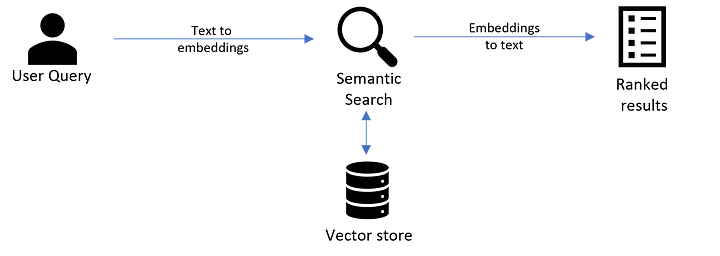

Fig. Retrieval process in a RAG system

In [16]:
def get_relevant_passage(query, db, n_results):
  passage = db.query(query_texts=[query], n_results=n_results)['documents'][0]
  return passage

In [17]:
relevant_text = get_relevant_passage("Sanctions on Russia",db,3)

# Generation

In a RAG system, generation step is the process of generating an answer for a user query using the relevant data provided by the retrieval step. The Language models use their intelligence/knowledge + knowledge enrichment provided by additional external data to generate an easy to understand answer for the user query.

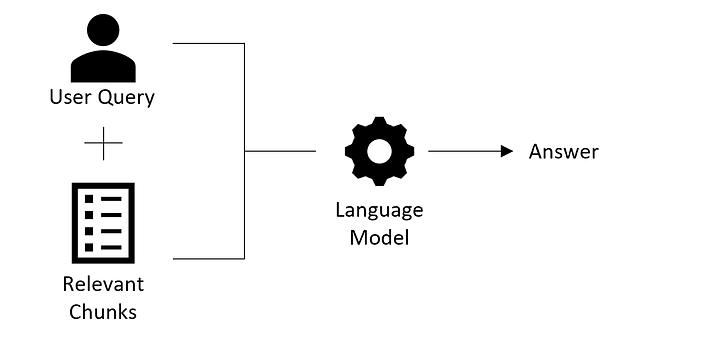

Fig. Generation step in a RAG system

In this section, we examine the prompt utilized for the generation process. The prompt includes a concise role description, the user’s query, and the relevant data. Depending on the specific problem at hand and the model being employed, it may be necessary to experiment with the prompt to determine the most effective approach

In [18]:
def make_rag_prompt(query, relevant_passage):
  escaped = relevant_passage.replace("'", "").replace('"', "").replace("\n", " ")
  prompt = ("""You are a helpful and informative bot that answers questions using text from the reference passage included below. \
  Be sure to respond in a complete sentence, being comprehensive, including all relevant background information. \
  However, you are talking to a non-technical audience, so be sure to break down complicated concepts and \
  strike a friendly and converstional tone. \
  If the passage is irrelevant to the answer, you may ignore it.
  QUESTION: '{query}'
  PASSAGE: '{relevant_passage}'

  ANSWER:
  """).format(query=query, relevant_passage=escaped)

  return prompt

The function given below is used to generate response for a given prompt with the Gemini Pro API

In [19]:
import google.generativeai as genai
def generate_response(prompt):
    #gemini_api_key = os.getenv("GEMINI_API_KEY")
    gemini_api_key = userdata.get('GOOGLE_API_KEY')
    if not gemini_api_key:
        raise ValueError("Gemini API Key not provided. Please provide GEMINI_API_KEY as an environment variable")
    genai.configure(api_key=gemini_api_key)
    model = genai.GenerativeModel('gemini-pro')
    answer = model.generate_content(prompt)
    return answer.text

# Bringing it all together

Bringing it all together
In the concluding step, let’s integrate the components we have constructed thus far. We will now proceed to code the following sequential steps:

1. Load the ChromaDB collection.
2. Retrieve the top n most relevant chunks of data for a given user query.
3. Construct the prompt by combining the user query with the relevant data.
4. Generate the response.

Here is the final generate_answer function that will do these tasks sequentially

In [20]:

def generate_answer(db,query):
    #retrieve top 3 relevant text chunks
    relevant_text = get_relevant_passage(query,db,n_results=3)
    prompt = make_rag_prompt(query,
                             relevant_passage="".join(relevant_text)) # joining the relevant chunks to create a single passage
    answer = generate_response(prompt)

    return answer




In [22]:
db=load_chroma_collection(path="/content/RAG/contents", #replace with path of your persistent directory
                          name="rag_experiment") #replace with the collection name

answer = generate_answer(db,query="what sanctions have been placed on Russia")
print(answer)


Together with allied nations, Russia is facing severe economic sanctions. Russia's largest banks have been barred from using the international financial system; its central bank is being blocked from defending the Russian ruble, thus deeming Putin's $630 billion war fund worthless; and its access to crucial technologies is being restricted, which will impact both its economy and military for years to come.


This is the response generated by the model based on the data provided

```
Sanctions imposed on Russia include cutting off its largest banks from the international financial system, preventing its central bank from defending the Russian Ruble, and choking off its access to technology that will weaken its military and economy. Furthermore, the US and its allies have closed off American airspace to all Russian flights.
```



## Conclusion

Voila, we just built a basic yet complete RAG system from scratch. The aim of this article was to provide an understanding of the working of a RAG system and the different components involved in it.